In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gpytorch.priors import GammaPrior
from edbo.bro import BO

%matplotlib inline

In [2]:
from data_loader import suzuki, load_CASP15

test_casp15 = load_CASP15()

print("CASP15 Dataset: ")
print(test_casp15)

CASP15 Dataset: 
      AL0_P  TM-score  TM-align  AL4_P    QCS  Z-score  Handed.     SS   DFM  \
0     77.78     0.794     0.797  88.89  87.09     7.43     0.91  0.463  0.17   
1     36.47     0.410     0.444  41.76  53.52     2.81     0.91  0.520  0.37   
2     72.17     0.888     0.893  87.39  97.86    12.90     0.94  0.650  0.09   
3     95.50     0.921     0.924  98.20  97.10     8.25     0.95  0.678  0.04   
4     57.27     0.571     0.569  64.55  67.85     3.86     0.92  0.462  0.22   
...     ...       ...       ...    ...    ...      ...      ...    ...   ...   
3999  95.50     0.929     0.932  98.20  97.33     8.25     0.95  0.694  0.04   
4000  95.93     0.972     0.972  96.83  99.00    10.91     0.97  0.780  0.05   
4001  95.50     0.943     0.946  98.20  97.77     8.25     0.96  0.698  0.04   
4002   0.00     0.388     0.405   0.00  26.25     0.84     0.80  0.204  0.32   
4003  88.33     0.733     0.733  98.33  79.79     5.93     0.90  0.429  0.06   

      GDT_TS  
0      

### Data Preprocessing

In [27]:
from edbo.utils import Data
from data_loader import suzuki, load_CASP15

#casp15 = Data(casp15()) # load casp data
casp15 = Data(load_CASP15()) # .sample(frac=0.5).reset_index(drop=True))

# drop any unwanted columns 
# casp15.drop(['AL0_P','QCS','Z-score','TM-align','SS','DFM','Handed.','AL4_P','TM-align']) 
#casp15.drop(['Handed.'])

# remaining variables: [TM-score]

# Standardize (normalize, etc)
#casp15.standardize(target='GDT_TS')

# Drop highly correlated features
#casp15.uncorrelated(target='GDT_TS', threshold=0.75)

print(casp15.data)

      AL0_P  TM-score  TM-align  AL4_P    QCS  Z-score  Handed.     SS   DFM  \
0     77.78     0.794     0.797  88.89  87.09     7.43     0.91  0.463  0.17   
1     36.47     0.410     0.444  41.76  53.52     2.81     0.91  0.520  0.37   
2     72.17     0.888     0.893  87.39  97.86    12.90     0.94  0.650  0.09   
3     95.50     0.921     0.924  98.20  97.10     8.25     0.95  0.678  0.04   
4     57.27     0.571     0.569  64.55  67.85     3.86     0.92  0.462  0.22   
...     ...       ...       ...    ...    ...      ...      ...    ...   ...   
3999  95.50     0.929     0.932  98.20  97.33     8.25     0.95  0.694  0.04   
4000  95.93     0.972     0.972  96.83  99.00    10.91     0.97  0.780  0.05   
4001  95.50     0.943     0.946  98.20  97.77     8.25     0.96  0.698  0.04   
4002   0.00     0.388     0.405   0.00  26.25     0.84     0.80  0.204  0.32   
4003  88.33     0.733     0.733  98.33  79.79     5.93     0.90  0.429  0.06   

      GDT_TS  
0      76.92  
1      38

#### Visualise the dataset

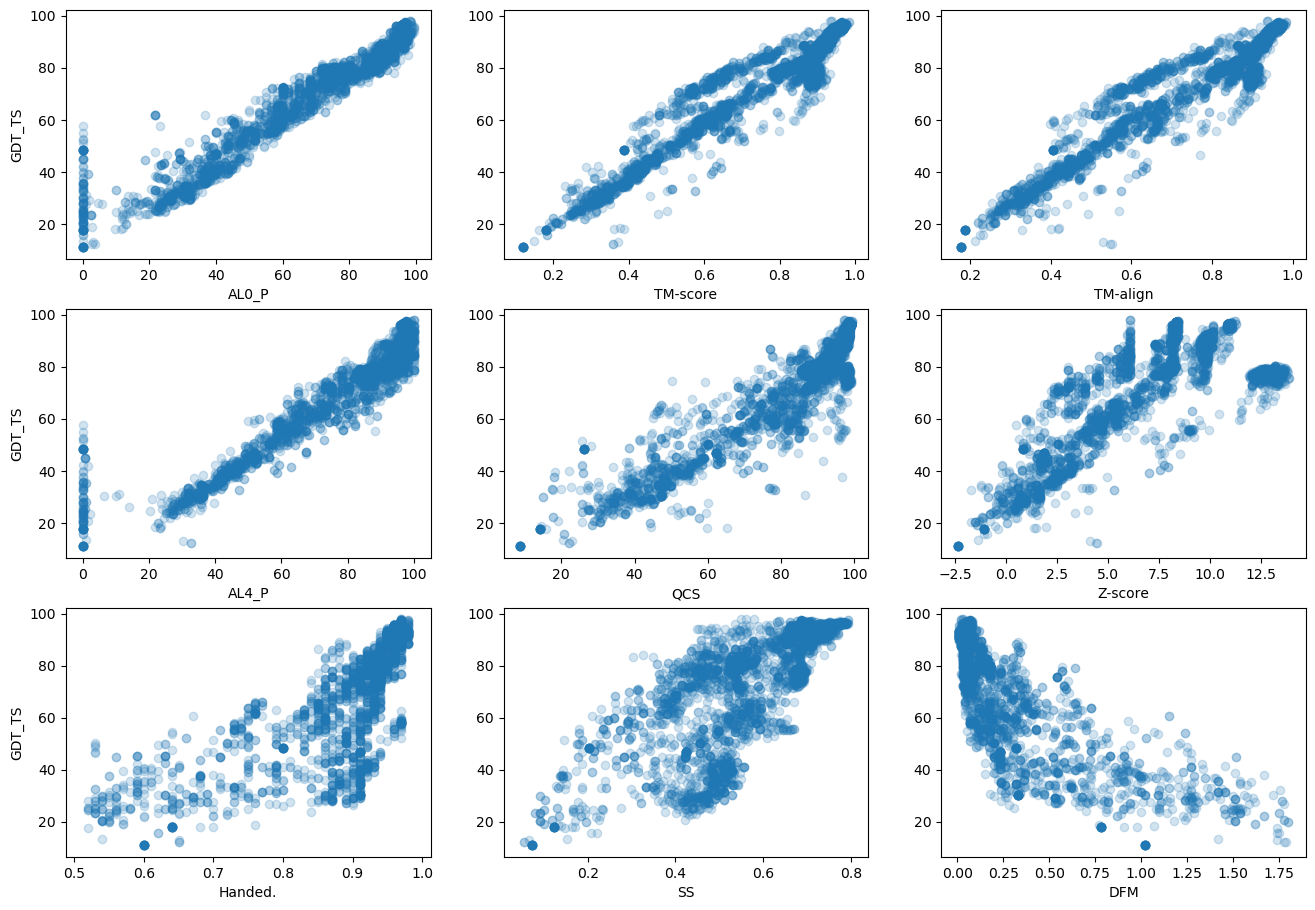

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from edbo.math_utils import pca

# extract the column names from the dataset
cols = casp15.data.columns

# output - GDT_TS column
y = casp15.data['GDT_TS']

# creating the plot
#pca_plot = ax.scatter3D(xx, yy, zz, c=zz, cmap='viridis');
fig = plt.figure(figsize=(16,11))
#fig.suptitle('CASP15 Dataset', fontsize=20)
axarr = fig.subplots(3,3)

axarr[0][0].scatter(casp15.data[cols[0]], y, alpha=0.2), axarr[0][0].set(xlabel=cols[0], ylabel='GDT_TS')
axarr[0][1].scatter(casp15.data[cols[1]], y, alpha=0.2), axarr[0][1].set(xlabel=cols[1])
axarr[0][2].scatter(casp15.data[cols[2]], y, alpha=0.2), axarr[0][2].set(xlabel=cols[2])
axarr[1][0].scatter(casp15.data[cols[3]], y, alpha=0.2), axarr[1][0].set(xlabel=cols[3], ylabel='GDT_TS')
axarr[1][1].scatter(casp15.data[cols[4]], y, alpha=0.2), axarr[1][1].set(xlabel=cols[4])
axarr[1][2].scatter(casp15.data[cols[5]], y, alpha=0.2), axarr[1][2].set(xlabel=cols[5])
axarr[2][0].scatter(casp15.data[cols[6]], y, alpha=0.2), axarr[2][0].set(xlabel=cols[6], ylabel='GDT_TS')
axarr[2][1].scatter(casp15.data[cols[7]], y, alpha=0.2), axarr[2][1].set(xlabel=cols[7])
axarr[2][2].scatter(casp15.data[cols[8]], y, alpha=0.2), axarr[2][2].set(xlabel=cols[8]);

plt.savefig('../../Report/Figures/dataset', bbox_inches='tight', pad_inches=0.1)


### Bayesian Optimization

In [73]:
from edbo.bro import BO

# TODO: play around with the surrogate model and use to instantiate BO

# Instantiate edbo.bro.BO
bo = BO(exindex=casp15.data,                        # Experiment index to look up results from
        domain=casp15.data.drop('GDT_TS', axis=1),  # Reaction space
        batch_size=1,                               # Choose 20 experiments on each iteraiton 
        acquisition_function='TS',                  # Use expected improvement
        fast_comp=True)                             # Speed up the simulations using gpytorch's fast computation features

# Run simulation
bo.simulate(iterations=10, seed=0)

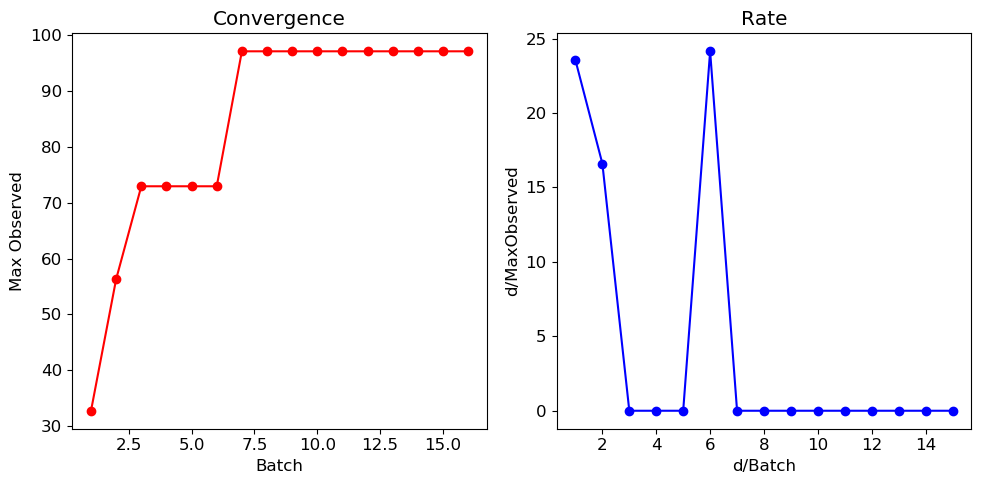

Model Performance:
RMSE: 8.4869620760226
R2_score: 0.847523460145289

Actual GDT_TS:
0       76.92
1       38.38
2       70.54
3       91.89
4       55.45
        ...  
3999    92.57
4000    96.49
4001    95.05
4002    48.33
4003    82.08
Name: GDT_TS, Length: 4004, dtype: float64

Predicted GDT_TS:
[72.50865  41.639656 80.91068  ... 85.481026 40.459686 66.87092 ]


In [74]:
import matplotlib.pyplot as plt
from edbo.math_utils import model_performance

# Plot convergence
bo.plot_convergence()

acq_summary = bo.acquisition_summary()

# predicted GDT_TS
GDT_TS_pred_mu = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain)) # GP posterior mean
GDT_TS_pred_var = np.sqrt(bo.model.variance(bo.obj.domain)) * bo.obj.scaler.std * 2 # GP posterior variance

# true GDT_TS
GDT_TS_actual = casp15.data['GDT_TS']

RMSE, R2_score = model_performance(GDT_TS_pred_mu, GDT_TS_actual)

print(f"Model Performance:\nRMSE: {RMSE}\nR2_score: {R2_score}")

print("\nActual GDT_TS:")
print(GDT_TS_actual)

print("\nPredicted GDT_TS:")
print(GDT_TS_pred_mu)


True Maximum: 97.92
Predicted Maximum: 88.57660675048828


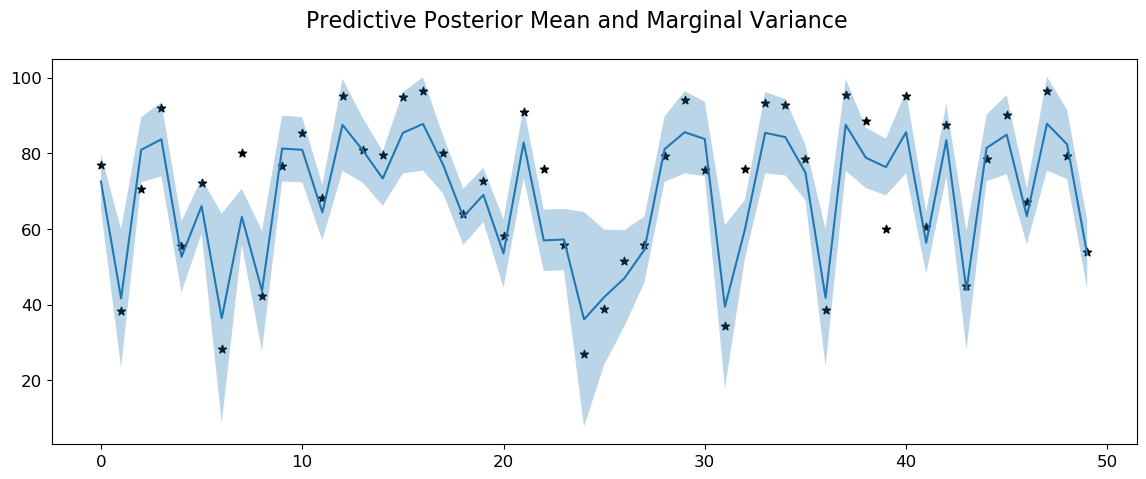

In [75]:
import matplotlib.pyplot as plt

x_star = range(4004)

num_pts = 50

#generate the plots
fig = plt.figure(figsize=(14,5))
fig.suptitle('Predictive Posterior Mean and Marginal Variance', fontsize=16)
ax = fig.add_subplot(111)

ax.scatter(x_star[:num_pts], GDT_TS_actual[:num_pts], marker='*', color='k')
ax.plot(GDT_TS_pred_mu[:num_pts], color='C0')
ax.fill_between(x=x_star[:num_pts], y1=GDT_TS_pred_mu[:num_pts]+GDT_TS_pred_var[:num_pts], y2=GDT_TS_pred_mu[:num_pts]-GDT_TS_pred_var[:num_pts], alpha=0.3);

# predicted maxima
print(f"True Maximum: {max(GDT_TS_actual)}")
print(f"Predicted Maximum: {max(GDT_TS_pred_mu)}")

#### Strategy 1: Generate $x^*$ and plot $\mu$, $\sigma^2$ for 1 or 2 variables


In [71]:
#print(f"AL4_P ranges from {min(casp15.data['AL4_P'])} to {max(casp15.data['AL4_P'])}")
print(f"TM-score ranges from {min(casp15.data['TM-score'])} to {max(casp15.data['TM-score'])}")

TM-score ranges from 0.121 to 0.983


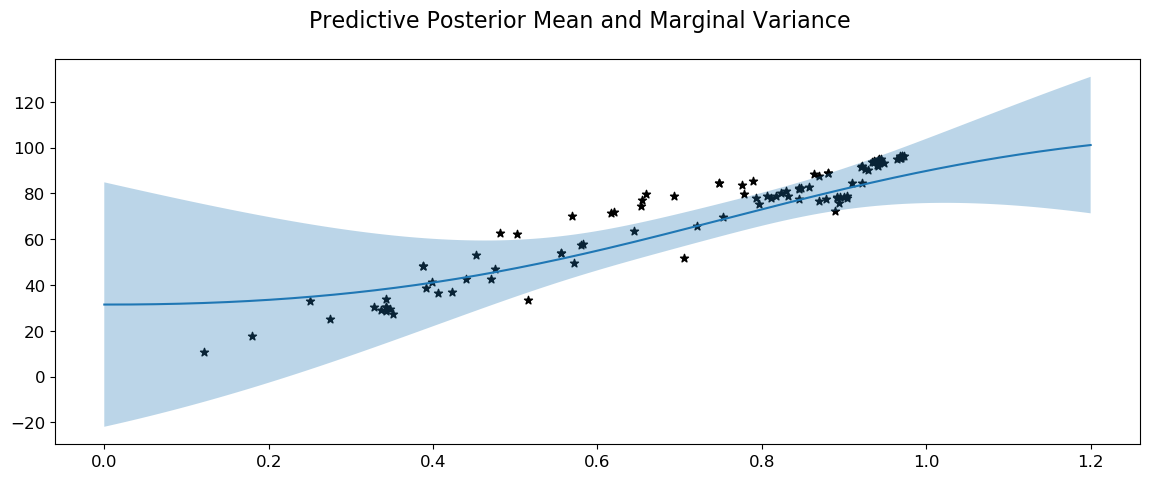

In [81]:
# this cell assumes that all columns have been dropped except for 1 feature
# (i.e., the domain is 1-dimensional)

samples = casp15.data.sample(n=100) # sample 5 points from the domain

domain_pts = samples['TM-score'].to_list()
output_pts = samples['GDT_TS'].to_list()

x_star = np.linspace(0, 1.2, 1000)

# predicted GDT_TS
GDT_TS_pred_mu = bo.obj.scaler.unstandardize(bo.model.predict(x_star)) # GP posterior mean
GDT_TS_pred_var = np.sqrt(bo.model.variance(x_star)) * bo.obj.scaler.std * 2 # GP posterior variance

#generate the plots
fig = plt.figure(figsize=(14,5))
fig.suptitle('Predictive Posterior Mean and Marginal Variance', fontsize=16)
ax = fig.add_subplot(111)

ax.scatter(domain_pts, output_pts, marker='*', color='k')
ax.plot(x_star, GDT_TS_pred_mu, color='C0')
ax.fill_between(x=x_star, y1=GDT_TS_pred_mu+GDT_TS_pred_var, y2=GDT_TS_pred_mu-GDT_TS_pred_var, alpha=0.3);
ax.set(xlabel='TM-score', ylabel='GDT_TS')


Running BO on feature AL0_P...
BO complete!
Acquisition function summary: 
        AL0_P  predicted GDT_TS  variance
340  0.813581         78.808792  0.772378

Running BO on feature TM-score...
BO complete!
Acquisition function summary: 
      TM-score  predicted GDT_TS  variance
3516  0.714617         71.505806  6.953135

Running BO on feature TM-align...
BO complete!
Acquisition function summary: 
      TM-align  predicted GDT_TS  variance
1873  0.684472          75.66143  1.700373

Running BO on feature AL4_P...
BO complete!
Acquisition function summary: 
       AL4_P  predicted GDT_TS  variance
2212  0.8597         77.139252  1.031032

Running BO on feature QCS...
BO complete!
Acquisition function summary: 
           QCS  predicted GDT_TS   variance
2478  0.783724         61.410378  31.038136

Running BO on feature Z-score...
BO complete!
Acquisition function summary: 
      Z-score  predicted GDT_TS   variance
3666     0.04         26.812954  39.583038

Running BO on feature SS.

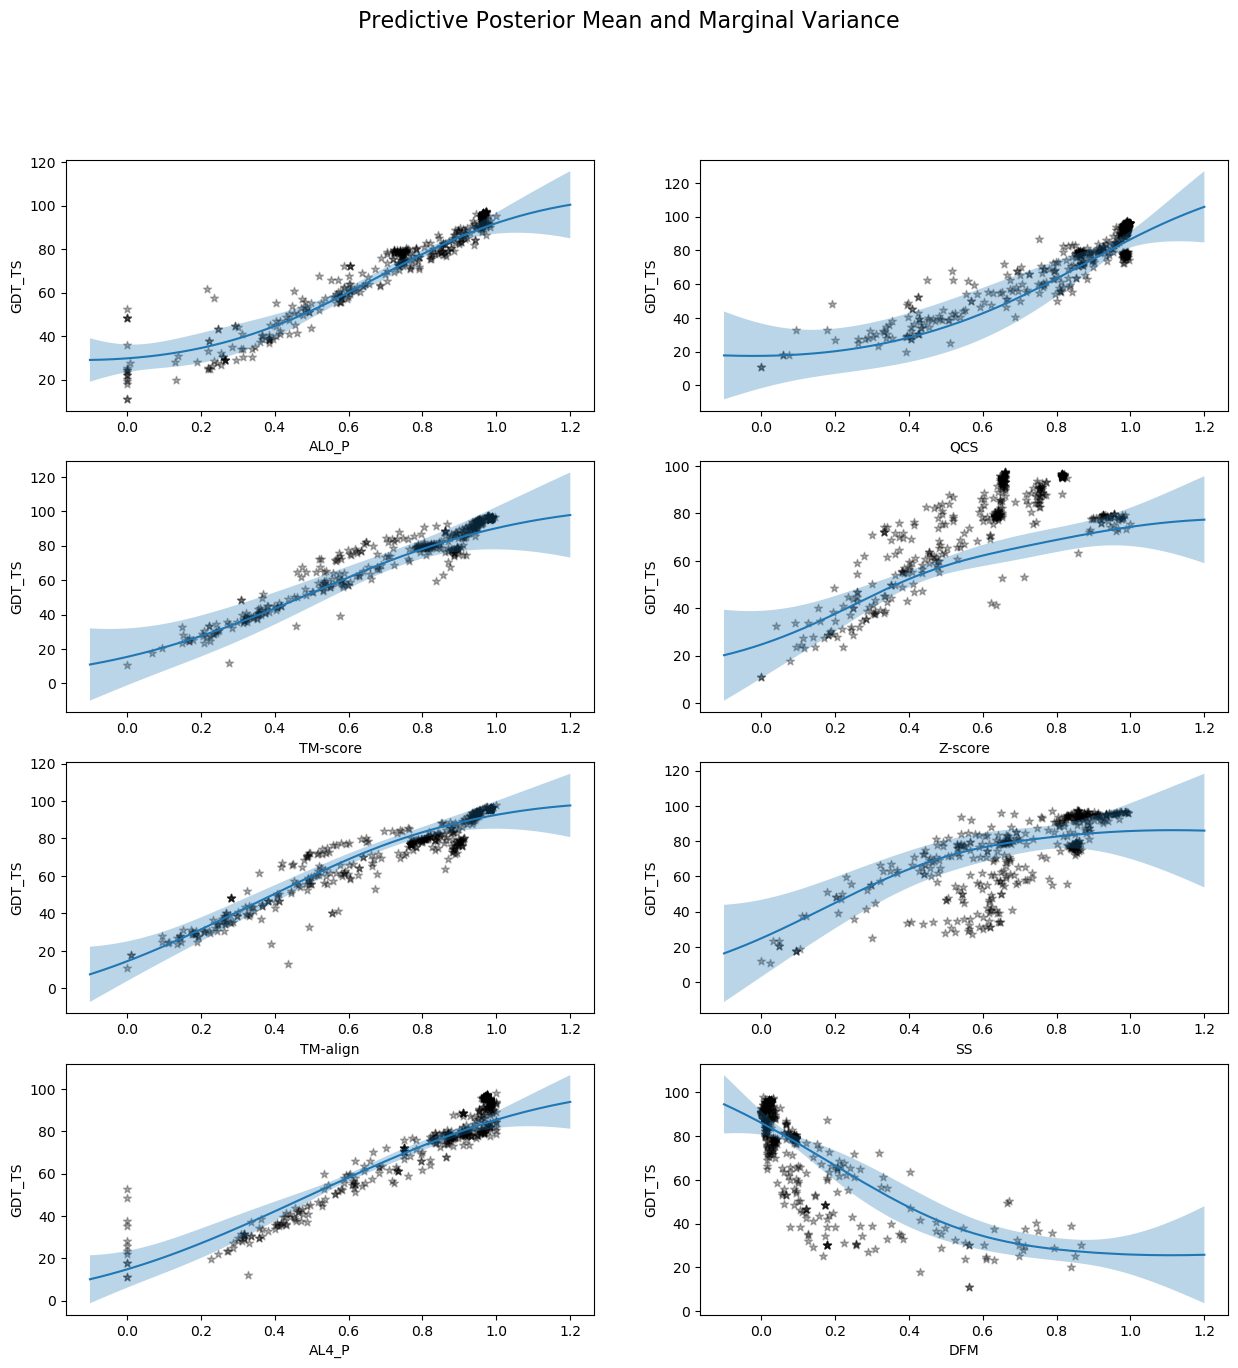

In [12]:
from edbo.bro import BO
from data_loader import load_CASP15
from edbo.math_utils import model_performance

#generate the plots
fig = plt.figure(figsize=(15,15))
fig.suptitle('Predictive Posterior Mean and Marginal Variance', fontsize=16)

axarr = fig.subplots(4, 2)

sp_idx = 0 # sub-plot index

for col in casp15.data.columns:
    if col == 'GDT_TS':
        break
    print(f"\nRunning BO on feature {col}...")
    
    exindex = Data(load_CASP15()) # start by making the entire dataset the exindex
    
    # then drop all columns except col
    columns_to_drop = exindex.data.columns.to_list()
    columns_to_drop.remove(col) # keep (i.e. don't drop) the specified current col
    columns_to_drop.remove('GDT_TS') # keep (i.e. don't drop) the output column
    
    exindex.drop(columns_to_drop)
    
    # standardise the column - need this for creating x_star later on
    exindex.standardize(target='GDT_TS')
    
    # Instantiate edbo.bro.BO
    bo = BO(exindex=exindex.data,                        # Experiment index to look up results from
            domain=exindex.data.drop('GDT_TS', axis=1),  # Reaction space
            batch_size=1,                               # Choose 1 experiments on each iteraiton 
            acquisition_function='EI',                  # Use expected improvement/thompson sampling
            fast_comp=True)                             # Speed up the simulations using gpytorch's fast computation features
    
    # Run simulation
    bo.simulate(iterations=20, seed=0)
    
    print("BO complete!")
    
    # Plot convergence
    #bo.plot_convergence()
    
    print("Acquisition function summary: ")
    print(bo.acquisition_summary())
    
    # true GDT_TS
    GDT_TS_actual = exindex.data['GDT_TS']

    #RMSE, R2_score = model_performance(GDT_TS_pred_mu, GDT_TS_actual)
    #print(f"Model Performance:\nRMSE: {RMSE}\nR2_score: {R2_score}")
    
    samples = exindex.data.sample(frac=0.1) # sample n points from the domain

    domain_pts = samples[col].to_list()
    output_pts = samples['GDT_TS'].to_list()

    x_star = np.linspace(-0.1, 1.2, 2000) # assumes domain standardised to (0, 1)
    
    # predicted GDT_TS over domain x_star
    GDT_TS_pred_mu = bo.obj.scaler.unstandardize(bo.model.predict(x_star)) # GP posterior mean
    GDT_TS_pred_var = np.sqrt(bo.model.variance(x_star)) * bo.obj.scaler.std * 2 # GP posterior variance
    
    i1 = sp_idx % 4   
    i2 = sp_idx // 4
    
    axarr[i1][i2].scatter(domain_pts, output_pts, marker='*', color='k', alpha=0.3)
    axarr[i1][i2].plot(x_star, GDT_TS_pred_mu, color='C0')
    axarr[i1][i2].fill_between(x=x_star, y1=GDT_TS_pred_mu+GDT_TS_pred_var, y2=GDT_TS_pred_mu-GDT_TS_pred_var, alpha=0.3);
    axarr[i1][i2].set(xlabel=col, ylabel='GDT_TS')
    
    sp_idx += 1
    
    

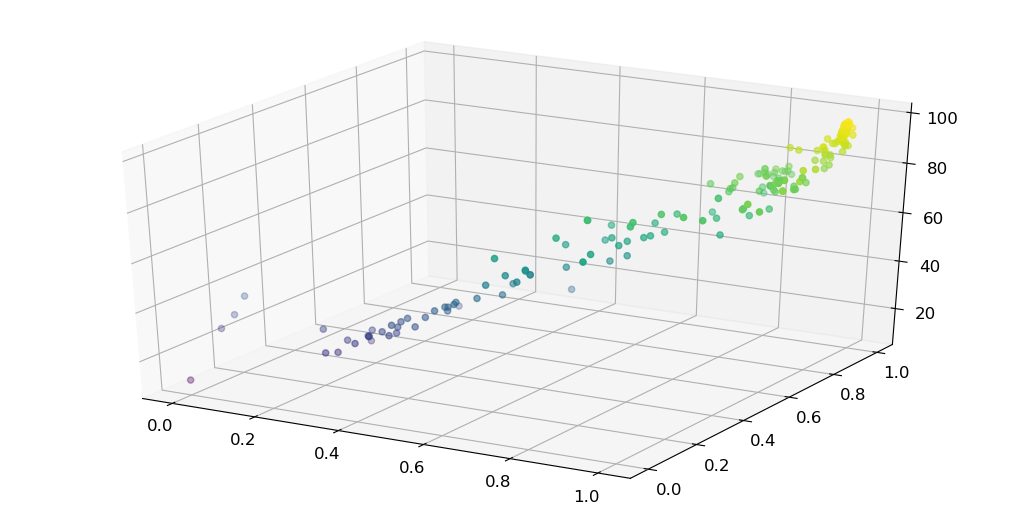

In [120]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from edbo.math_utils import pca

xx = casp15.data['AL4_P']
yy = casp15.data['TM-align']
zz = casp15.data['GDT_TS']

# creating figure
fig = plt.figure()
ax = Axes3D(fig)
 
# creating the plot
two_var_plot = ax.scatter3D(xx, yy, zz, c=zz, cmap='viridis');

#### Strategy 2: Run PCA and generate x* along the axis of the principle component

Explained variance = 0.9859352303098255
             pc1        pc2
0     -12.978742  -1.382273
1      58.018251  -0.422048
2     -14.255779  11.364978
3     -34.673322  -2.905131
4      24.192005  -3.026623
...          ...        ...
3999  -34.786552  -2.709322
4000  -35.256811  -0.769870
4001  -35.003098  -2.334818
4002  119.464938   2.763976
4003  -21.554251 -14.833532

[4004 rows x 2 columns]


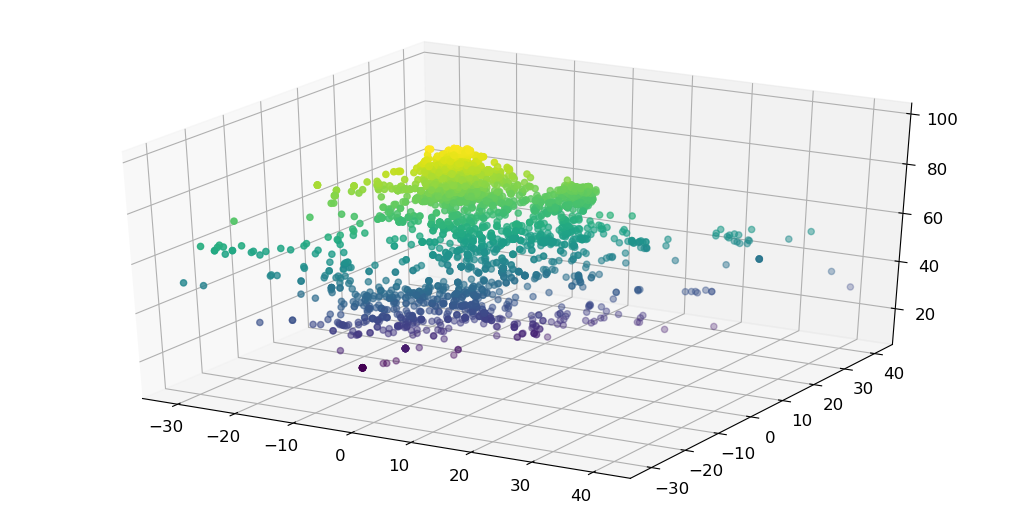

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from edbo.math_utils import pca

# Run PCA on the dataset
explained_variance = pca(bo.obj.domain, n_components=2)

print(explained_variance)

xx = explained_variance['pc2']
yy = explained_variance['pc2']
zz = GDT_TS_actual

# creating figure
fig = plt.figure()
ax = Axes3D(fig)
 
# creating the plot
pca_plot = ax.scatter3D(xx, yy, zz, c=zz, cmap='viridis');

#ax.contour(xx, yy, zz, c=zz, cmap='viridis')

In [ ]:
# strategy 1: Generate x* and plot mu, var for 1 or 2 variables


# strategy 2: Run PCA and generate x* along the axis of the principle component


# strategy 3: Run t-SNE to reduce dimension to N components and generate x* in the lower-dim space



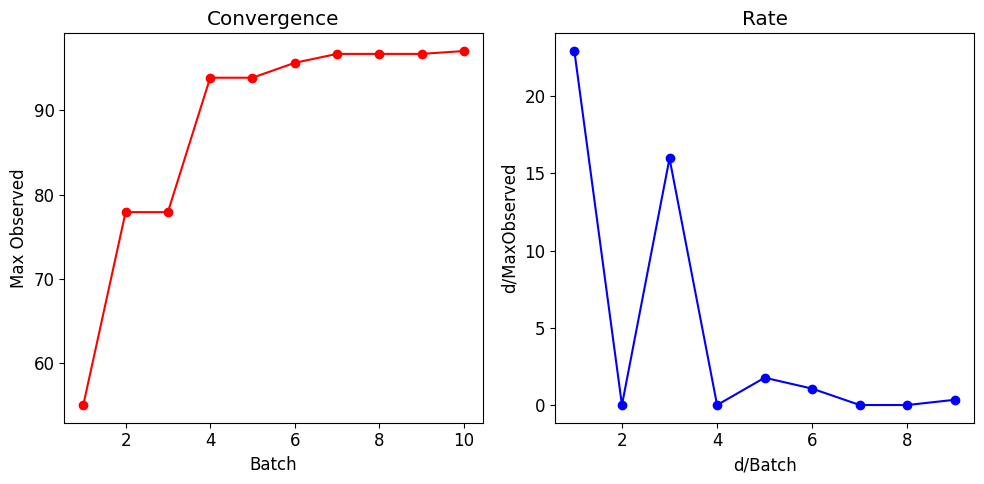

In [49]:
from edbo.bro import BO

# TODO: play around with the surrogate model and use to instantiate BO

# Instantiate edbo.bro.BO
bo = BO(exindex=casp15.data,                        # Experiment index to look up results from
        domain=casp15.data.drop('GDT_TS', axis=1),  # Reaction space
        batch_size=1,                               # Choose 1 experiments on each iteraiton 
        acquisition_function='TS',                  # Use expected improvement
        init_method='rand',
        fast_comp=True)                             # Speed up the simulations using gpytorch's fast computation features

# Run simulation
bo.simulate(iterations=9, seed=0)

# Plot convergence
bo.plot_convergence()

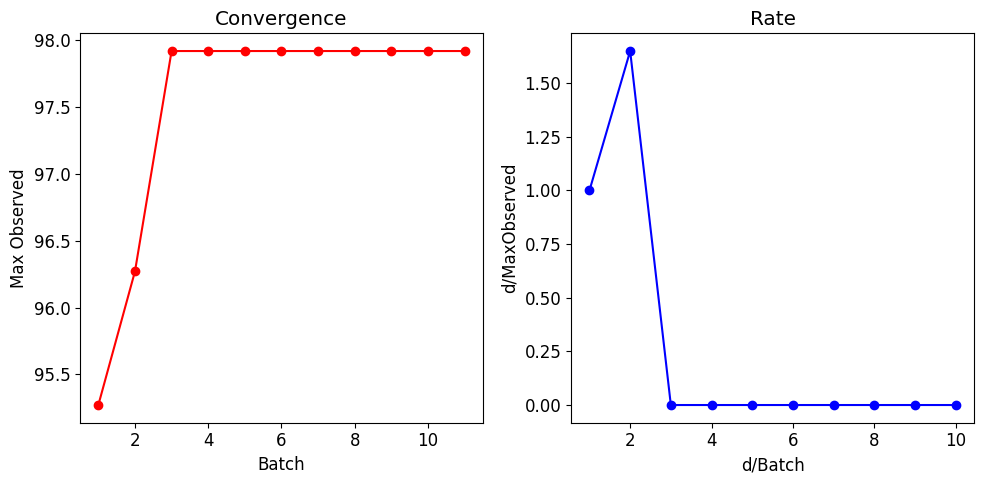

In [33]:
from edbo.bro import BO

# TODO: play around with the surrogate model and use to instantiate BO

# Instantiate edbo.bro.BO
bo = BO(exindex=casp15.data,                      # Experiment index to look up results from
        domain=casp15.data.drop('GDT_TS', axis=1),  # Reaction space
        batch_size=20,                          # Choose 20 experiments on each iteraiton 
        acquisition_function='TS',              # Use expected improvement
        fast_comp=True)                         # Speed up the simulations using gpytorch's fast computation features

# Run simulation
bo.simulate(iterations=9, seed=0)

# Plot convergence
bo.plot_convergence()

### Simulations

In [28]:
from edbo.models import GP_Model, RF_Model, Random
from edbo.plot_utils import average_convergence, plot_avg_convergence
import pandas as pd

# Function for simulating different BO parameters

def simulate(data,                 # Data container (vide supra)
             acq_func,             # Acquisition function: 'EI', 'PI', 'UCB', 'TS', ...
             model=GP_Model,       # Surrogate model: GP_Model or RF_Model
             init_method='rand',   # Initialization method: 'rand', 'pam', 'kmeans'
             batch_size=1,        # Parallel acquisition: int
             iterations=9,         # Number of iterations to run each simulation for
             average_of=10,        # Number of simulations to average
             export_path=None,     # Export the simulation results to a CSV file
             plot=False):          # Plot the average and standard deviation averaged convergence
    """
    Simulation function which averages BO runs with given optimization paramters.
    """
    
    # Average N optimizations with different random initializations
    results = []
    for i in range(average_of):
        
        print(f"Experiment {i+1}/{average_of}...")
        
        # Use random function if the acquisition function is random selection
        if acq_func == 'rand':
            bo = BO(exindex=data.data,
                    domain=data.data.drop('GDT_TS', axis=1),
                    init_method=init_method,
                    model=Random,
                    batch_size=batch_size,
                    acquisition_function=acq_func)
        # Otherwise use specified model
        else:
            bo = BO(exindex=data.data,
                    domain=data.data.drop('GDT_TS', axis=1),
                    model=model,
                    init_method=init_method,
                    batch_size=batch_size,
                    acquisition_function=acq_func,
                    fast_comp=True)                            # Use gpytorch fast computation features
            
        # Simulate
        bo.init_seq.visualize = False
        bo.simulate(iterations=iterations, seed=i)
        
        # Append results to record
        results.append(bo.obj.results_input()['GDT_TS'].values)
        
    # Save the results to a CSV file
    results = pd.DataFrame(results)
    if export_path != None:
        results.to_csv(export_path)
        
    # Average performance
    index, mean, std = average_convergence(results, batch_size)
    
    # Plot
    if plot:
        plot_avg_convergence(results, batch_size)
        
    return results, mean, std

Acquisition Function: TS
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...
Acquisition Function: EI
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagona

Acquisition Function: rand
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...
Acquisition Function: eps-greedy
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...
Acquisition Function: MeanMax
Experiment 1/5...
Experiment 2/5...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


Experiment 3/5...
Experiment 4/5...
Experiment 5/5...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarni

Acquisition Function: VarMax
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarni

Average performance for all acquisition functions:


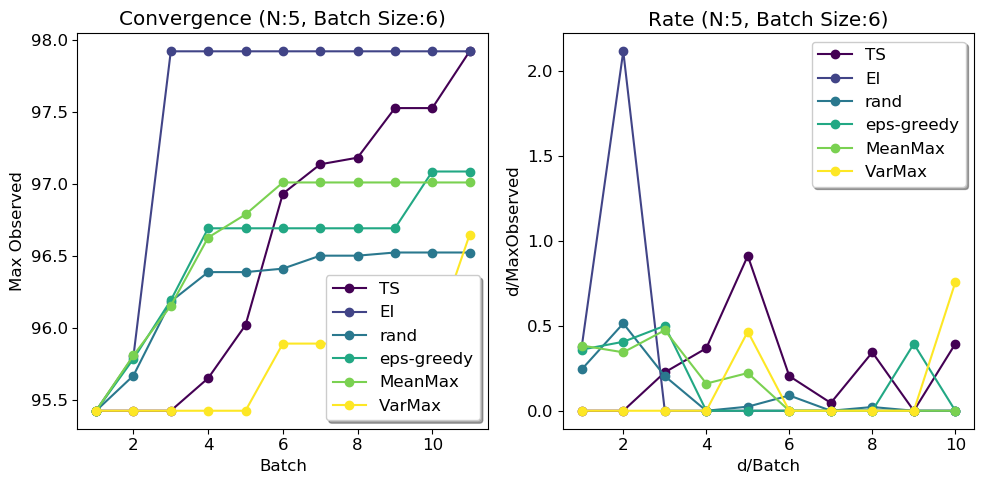

In [29]:
from edbo.plot_utils import compare_convergence

# Simulation
acq_funcs = ['TS', 'EI', 'rand', 'eps-greedy', 'MeanMax', 'VarMax']
acq_func_results = []

for acq_func in acq_funcs:
    # Run simulations
    print('Acquisition Function:', acq_func)
    results, mean, std = simulate(casp15,          # Data from reaction 
                              acq_func,            # Iterate over acq. funcs.
                              model=GP_Model,      # Gaussian process model
                              init_method='rand',  # Random initialization
                              batch_size=5,        # Choose 5 samples at a time
                              iterations=12,        # Run for 12 iterations
                              average_of=5,       # Run with 10 different random seeds
                              export_path='simulation_output_acq_funcs', # Don't save the results
                              plot=True)           # Plot the average results
    # Save results
    acq_func_results.append(mean)

# Compare average convergence for each acquisition function
print('Average performance for all acquisition functions:')
compare_convergence(acq_func_results, 6, acq_funcs)

Acquisition Function: TS
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...


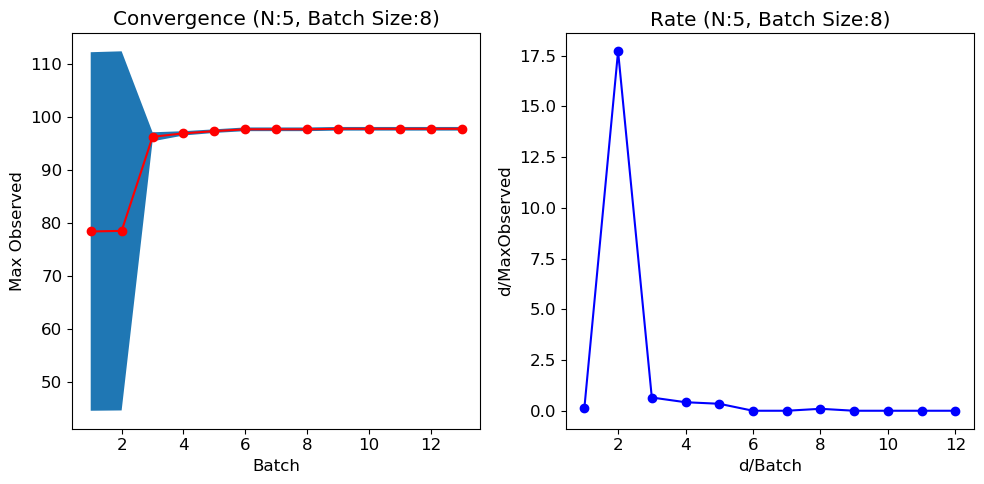

Acquisition Function: EI
Experiment 1/5...


C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(domain)) + 1e-6
C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(domain)) + 1e-6
C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(domain)) + 1e-6
C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(domain)) + 1e-6
C:\Users

Experiment 2/5...
Experiment 3/5...


C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(domain)) + 1e-6
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(do

Experiment 4/5...
Experiment 5/5...


C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(domain)) + 1e-6
C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(domain)) + 1e-6
C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\edbo\acq_func.py:267: RuntimeWarning: invalid value encountered in sqrt
  stdev = np.sqrt(model.variance(domain)) + 1e-6


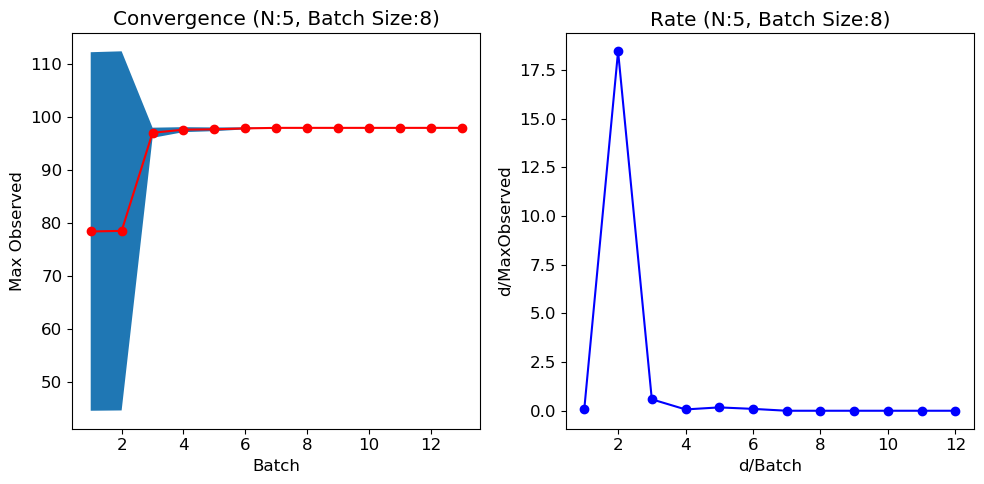

Acquisition Function: rand
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...


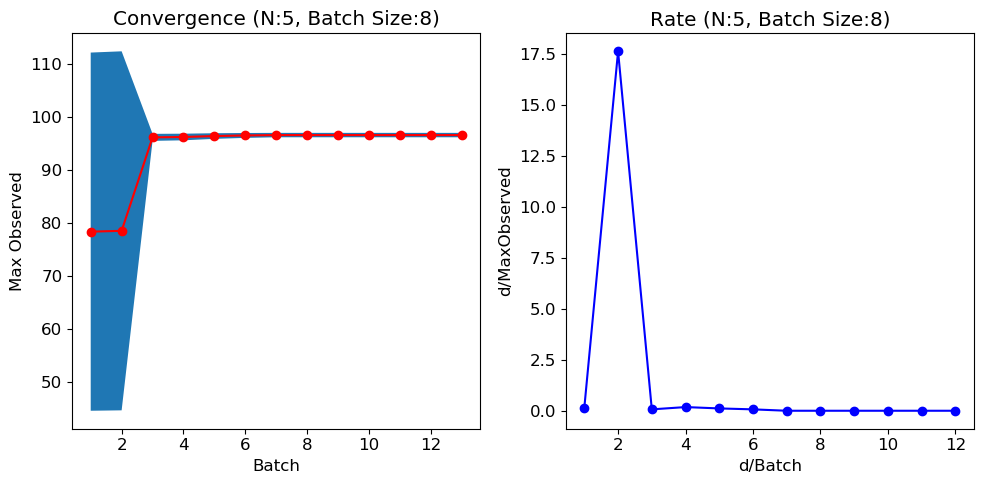

Acquisition Function: eps-greedy
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...
Experiment 4/5...
Experiment 5/5...


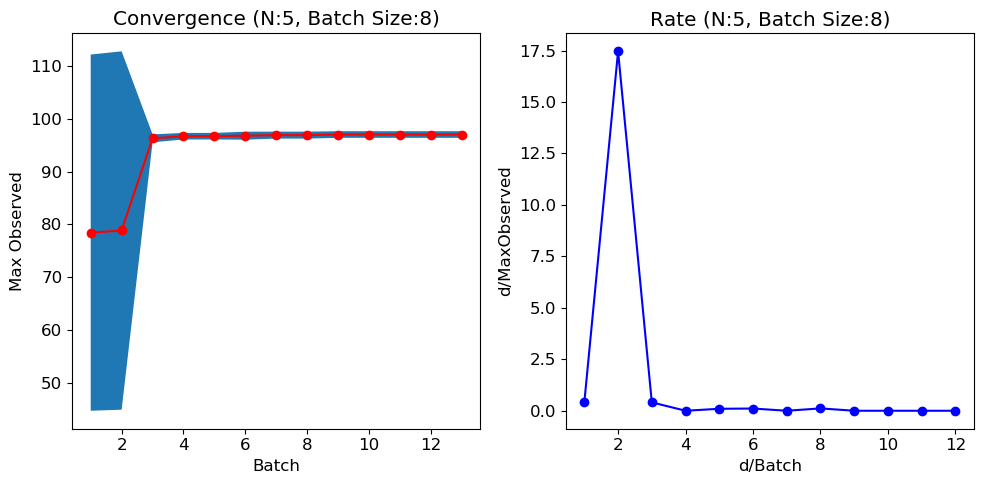

Acquisition Function: MeanMax
Experiment 1/5...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagona

Experiment 2/5...
Experiment 3/5...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarni

Experiment 4/5...
Experiment 5/5...


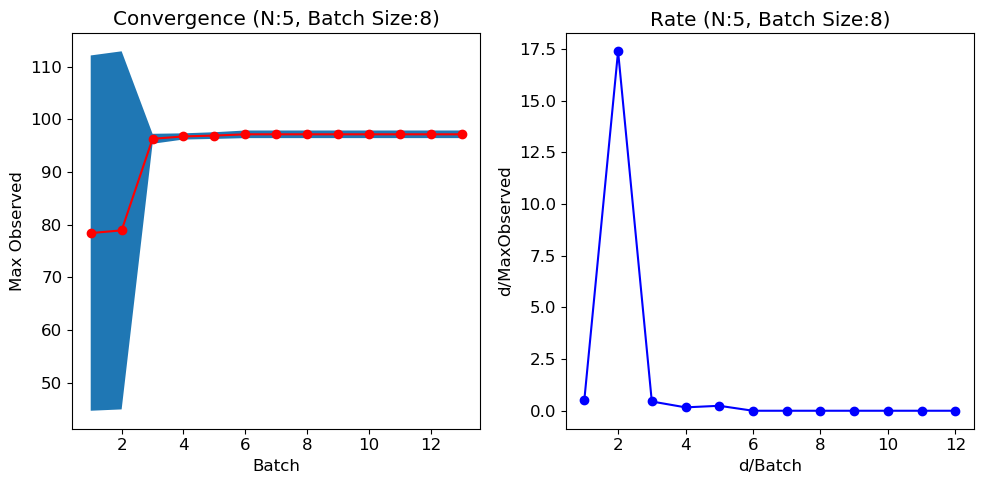

Acquisition Function: VarMax
Experiment 1/5...
Experiment 2/5...
Experiment 3/5...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagona

Experiment 4/5...
Experiment 5/5...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\luc

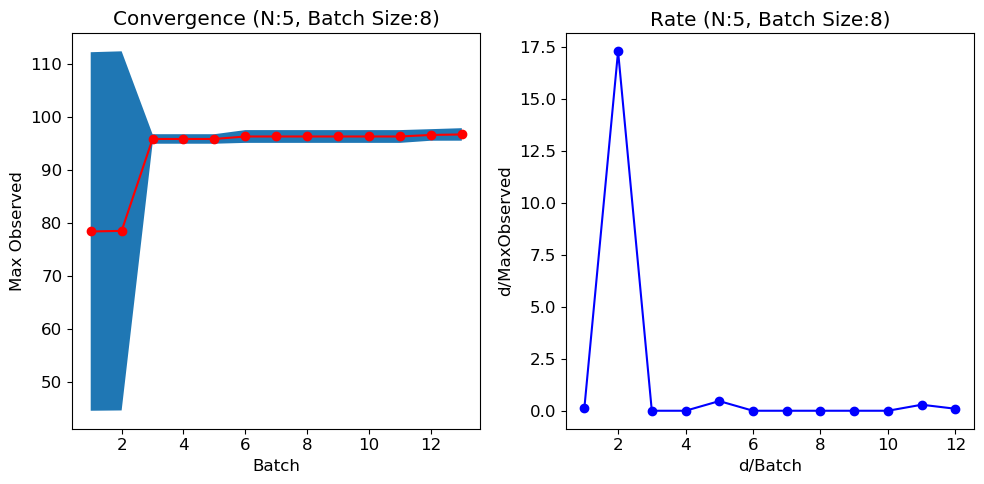

Average performance for all acquisition functions:


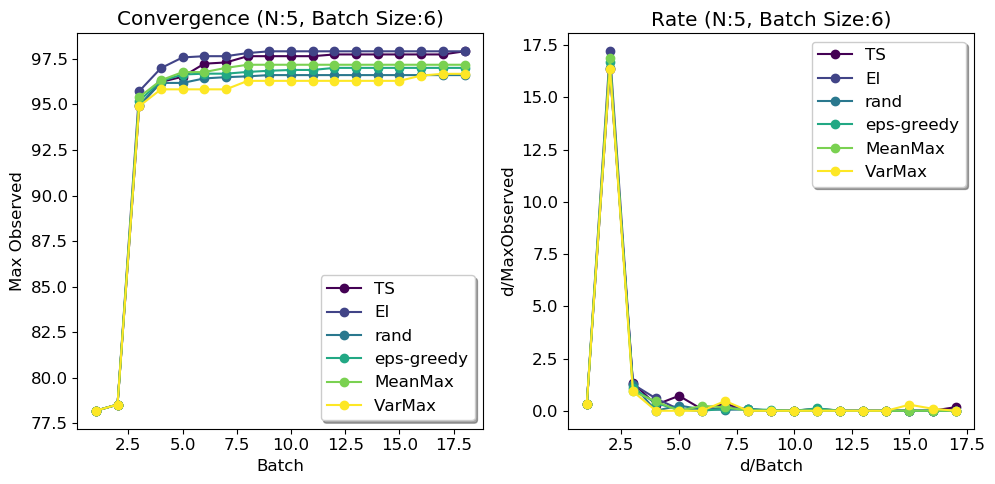

In [31]:
from edbo.plot_utils import compare_convergence

# Simulation
acq_funcs = ['TS', 'EI', 'rand', 'eps-greedy', 'MeanMax', 'VarMax']
acq_func_results = []

for acq_func in acq_funcs:
    # Run simulations
    print('Acquisition Function:', acq_func)
    results, mean, std = simulate(casp15,          # Data from reaction 
                              acq_func,            # Iterate over acq. funcs.
                              model=GP_Model,      # Gaussian process model
                              init_method='rand',  # Random initialization
                              batch_size=8,        # Choose 5 samples at a time
                              iterations=12,        # Run for 12 iterations
                              average_of=5,       # Run with 10 different random seeds
                              export_path='simulation_output_acq_funcs', # Don't save the results
                              plot=True)           # Plot the average results
    # Save results
    acq_func_results.append(results)

# Compare average convergence for each acquisition function
print('Average performance for all acquisition functions:')
compare_convergence(acq_func_results, 6, acq_funcs)

#### Ideas

- Visualise the surrogate model space (posterior) after certain numbers of iterations to show exploration/exploitation
- Visualise the separation of the data in space for a few features